In [ ]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
import numpy as np
import hfb_dir_init
from importlib import reload
from mmfutils.contexts import NoInterrupt

<IPython.core.display.Javascript object>

# Homogeneous Matter

Here we tabulate the various integrands required for homogeneous quantities.  These are implemented in the `tf_completion.py` file.

$$
  \newcommand{\E}{\mathcal{E}}
  \newcommand{\e}{\epsilon}
  \mat{M} = \begin{pmatrix}
    \overbrace{\frac{\hbar^2k_a^2}{2m_a} - \mu_a}^{\e_a} & \Delta\\
    \Delta^\dagger & - \underbrace{\left(\frac{\hbar^2k_b^2}{2m_b} - \mu_b\right)}_{\e_b}
  \end{pmatrix},\\
  \e_{\pm} = \frac{\e_a \pm \e_b}{2}, \qquad
  \omega_{\pm} = \e_- \pm \overbrace{\sqrt{\e_+^2 + \abs{\Delta}^2}}^{E},
$$
\begin{align}
  \newcommand{\intdk}{\int \frac{\d^d{k}}{(2\pi)^d}\;}
  n_+ &= \intdk\overbrace{\left(1 - \frac{\epsilon^+_k}{E_k}
               \underbrace{\bigl(f_\beta(\omega_-) - f_\beta(\omega_+)\bigr)}_{f_\nu}
          \right)}^{f_+}, &
  n_- &= \intdk\overbrace{\bigl(f_\beta(\omega_+) - f_\beta(-\omega_-)\bigr)}^{f_-},\\
  n_a &= \intdk\overbrace{\frac{f_+ + f_-}{2}}^{f_a}, &
  n_b &= \intdk\overbrace{\frac{f_+ - f_-}{2}}^{f_a},\\
  \tau_a &= \intdk k_a^2f_a, &
  \tau_b &= \intdk k_b^2f_b,\\
  \tau_+ &= \intdk (k_a^2f_a + k_b^2f_b), &
  \tau_- &= \intdk (k_a^2f_a - k_b^2f_b),\\
  \nu &= \intdk\frac{\Delta}{2E}
  \overbrace{\bigl(f_\beta(\omega_-)-f_\beta(\omega_+)\bigr)}^{f_\nu}, &
  \kappa &= \intdk \left(
    \frac{\hbar^2k_a^2}{2m_a}f_a + \frac{\hbar^2k_b^2}{2m_b}f_b 
    - \frac{\abs{\Delta}^2}{2E}f_\nu\right),\\
  \tilde{C} &= \frac{1}{2}\intdk \left(
    \frac{1}{\epsilon_+ + \I 0^+} - \frac{f_\nu}{E}\right).
\end{align}

# Lattice

When working on a lattice, one can use the homogeneous equations, by replacing the integral with a sum over lattice momenta.  We give the explicit relationships here for a box of length $L$ with $N$ points and index $n \in [0, 1, \cdots N-1]$.  Note that the ordering of the indices $m$ for $k_m$ is different than listed because of how the FFT is implemented numerically. (See the following code for the explicit ordering.)  The order listed can be obtained from this using `np.fft.fftshift()`.

$$
  \d{x} = \frac{L}{N}, \qquad
  x_n = \left.n\d{x}\right|_{n=0}^{N-1} - \frac{L}{2}, \qquad
  k_m = k_B + \left.\frac{2\pi m}{L}\right|_{m=-\ceil{\frac{N}{2}}}^{\floor{\frac{N-1}{2}}}
      = \frac{2\pi m + \theta_B}{L},\\
  \mat{U}_{mn} = e^{-\I(x_n + L/2)k_m} = e^{-\frac{2\pi \I nm}{N}}e^{-\I Lk_m/2}, \qquad
  \mat{U}^{-1} = \frac{1}{N}\mat{U}^{\dagger}.
$$

Here we have included the Bloch momentum $k_B = \frac{\theta_B}{2\pi L}$ used when one implements a twist $\pi/2 \leq \theta_B < \pi/2$ which acts to fill in the missing momenta.

In [ ]:
import numpy as np
N, L = 8, 2.0
dx = L/N
x = np.arange(N) * dx - L/2.0
k = 2*np.pi * np.fft.fftfreq(N, dx)
m = ((np.arange(N)+N//2) % N - N//2)
k_ = 2*np.pi * m / L
assert np.allclose(k, k_)
assert np.allclose(np.fft.fftshift(m), np.arange(-(N-1)//2, (N+1)//2))
assert np.allclose(np.fft.fftshift(m), np.arange(-np.ceil(N/2), np.floor((N+1)/2)))

U = np.exp(-1j*(x[None, :] + L/2.0)*k[:, None])
Uinv = U.conj().T/N
f = np.random.random(N) + np.random.random(N)*1j - 0.5 - 0.5j
assert np.allclose(np.fft.fft(f), U.dot(f))
assert np.allclose(np.fft.ifft(f), np.linalg.inv(U).dot(f))
assert np.allclose(np.fft.ifft(f), Uinv.dot(f))

From this we can see that summing over all lattice momentum while averaging over twist will completely remove any IR components of the error leaving only those due to the limited maximum $k_c \approx \pi N/L = \pi/\d{x}$ which can only be removed by decreasing the lattice spacing $\d{x}$.  For this reason, we usually provide the user with the option of specifying $\d{x}$ rather than requiring both $L$ and $N$.

# Test Cases

## 1D

In 1D, we have the following:

$$
  n_+ = \frac{k_F}{\pi}, \qquad 
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^3}{3m\pi} = \frac{2}{3}n_+\e_F, \qquad
  \tilde{C} = -\frac{m}{\hbar^2k_F} = -\frac{1}{g} = \frac{1}{v_0} = -\frac{\nu}{\Delta},\\
  \frac{\mu}{\e_F} = 0.28223521359748843,\qquad
  \frac{\Delta}{\e_F} = 0.411726229961806.
$$

# Examples

In [4]:
import numpy as np
import homogeneous;reload(homogeneous)
hbar = m = kF = 1.0
nF = kF/np.pi
eF = (hbar*kF)**2/2/m
E_FG = 2*nF*eF/3
C_unit = m/hbar**2/kF

Nx = 32
Lx = 10.0

mu = 0.28223521359748843*eF
delta = 0.411726229961806*eF
s = homogeneous.Homogeneous1D()
res = s.get_BCS_v_n_e((mu, mu), delta)
print(res.v_0)
assert np.allclose(res.v_0.n, 1.0)
assert np.allclose(sum(res.ns).n, nF)
res.v_0.n, sum(res.ns).n

(2.201375025501774, 0.845071474261069)

In [ ]:
# Here we do the same integrals using a grid:
L = 10.0
N = 32
s = homogeneous.Homogeneous1D(Lxyz=(L,), Nxyz=(N,))
res = s.get_BCS_v_n_e((mu, mu), delta, twist=1)
res.v_0.n, sum(res.ns).n

In [ ]:
# Now using the lattice code:
from mmf_hfb import vortex_2d;reload(vortex_2d)

s = vortex_2d.BCS_1D(Nx=N, Lx=L)
res = s.get_densities((mu, mu), delta)
v_0 = -delta/res.nu.mean().real
v_0, (res.n_a + res.n_b).mean()

## 2D

In 2D, we must compute results but we seem to have:

$$
  n_+ = \frac{k_F^2}{2\pi}, \qquad
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^4}{8m\pi} = \frac{1}{2}n_+\e_F, \qquad
  \tilde{C} = 0 = -\frac{1}{g_c} + \Lambda_c = -\frac{\nu}{\Delta} + \Lambda_c,\\
  \frac{\mu}{\e_F} = \frac{1}{2},\qquad
  \frac{\Delta}{\e_F} = \sqrt{2}\\
$$

In [ ]:
import numpy as np
from mmf_hfb import homogeneous;reload(homogeneous)
hbar = m = kF = 1.0
nF = kF**2/2/np.pi
eF = (hbar*kF)**2/2/m
E_FG = nF*eF/2

N = 16
L = 10.0

mu = 0.5 * eF
delta = np.sqrt(2) * eF
s = homogeneous.Homogeneous2D()
n_a, n_b = s.get_densities((mu, mu), delta)
assert np.allclose((n_a + n_b).n, nF)
(n_a + n_b)/nF

#res = s.get_BCS_v_n_e((mu, mu), delta)
#assert np.allclose(res.v_0.n, 1.0)
#assert np.allclose(sum(res.ns).n, nF)
#res.v_0.n, sum(res.ns).n / nF

In [ ]:
# Here we do the same integrals using a grid:
Nxyz = (N,)*2
Lxyz = (L,)*2
s = homogeneous.Homogeneous2D(Nxyz=Nxyz, Lxyz=Lxyz)
n_a, n_b = s.get_densities((mu, mu), delta)
(n_a + n_b)/nF

In [ ]:
# Now using the lattice code:
from mmf_hfb import vortex_2d;reload(vortex_2d)

s = vortex_2d.BCS_2D(Nxy=Nxyz, Lxy=Lxyz)
res = s.get_densities((mu, mu), delta)
(res.n_a + res.n_b).mean()/nF

## 3D

Here we check the results for homogeneous matter in various dimensions.  In 3D can compare these with the results we know for the BdG equation (Eagles-Leggett model) at unitarity:

$$
  \newcommand{\E}{\mathcal{E}}\newcommand{\e}{\epsilon}
  n_+ = n_a+n_b = \frac{k_F^3}{3\pi^2}, \qquad
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^5}{10m\pi^2} = \frac{3}{5}n_+\e_F, \qquad
  \tilde{C} = 0,
$$
\begin{align*}
  \xi = \frac{\E}{\E_{FG}}
      = \frac{\mu}{\e_F} &= 0.59060550703283853378393810185221521748413488992993\cdots\\
  \frac{\Delta}{\e_F} &= 0.68640205206984016444108204356564421137062514068346\cdots\\
  \frac{\Delta}{\mu}& = 1.162200561790012570995259741628790656202543181557689\cdots.
\end{align*}

In [5]:
import numpy as np
from mmf_hfb import homogeneous;reload(homogeneous)
hbar = m = kF = 1.0
xi = 0.59060550703283853378393810185221521748413488992993
nF = kF**3/3/np.pi**2
eF = (hbar*kF)**2/2/m
E_FG = 3*nF*eF/5

N = 8
L = 10.0

mu = xi * eF
delta = 0.68640205206984016444108204356564421137062514068346 * eF
s = homogeneous.Homogeneous3D()
n_a, n_b = s.get_densities((mu, mu), delta)
assert np.allclose((n_a + n_b).n, nF)
(n_a + n_b)/nF

(2.3691964134057666, 0.8450821302213538)

In [ ]:
# Here we do the same integrals using a grid:
Nxyz = (N,)*3
Lxyz = (L,)*3
s = homogeneous.Homogeneous3D(Nxyz=Nxyz, Lxyz=Lxyz)
n_a, n_b = s.get_densities((mu, mu), delta)
(n_a + n_b)/nF

In [7]:
# Now using the lattice code:
from mmf_hfb import vortex_2d;reload(vortex_2d)

s = vortex_2d.BCS_3D(Nxyz=Nxyz, Lxyz=Lxyz)
res = s.get_densities((mu, mu), delta)
(res.n_a + res.n_b).mean()/nF

Populating the interactive namespace from numpy and matplotlib


(2.369196413405766, 0.8450821302213535)

# Error Check
* We check how the relative errors for $\nu_0$ and densities vary with respect to $N$, $L$, and twist number

In [8]:
%pylab inline --no-import-all
import bcs;reload(bcs)
import homogeneous;reload(homogeneous)

delta = 1.0
mu_eff = 1.0
m = 1.0
v_0, n, mu, e_0 = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
print(v_0,n,mu)
N_twist = 2

def get_err(N, L, N_twist=1):
    b = homogeneous.Homogeneous1D()
    res = b.get_BCS_v_n_e((mu_eff, mu_eff), delta, L=L, N=N, twist=N_twist)
    v0,ns,mus = res
    na,nb = ns
    k_max = np.pi*N/L
    dn_UV = 2*m**2*delta**2/3/np.pi/k_max**3 + 8*m**3*mu_eff*delta**2/5/np.pi/k_max**5
    dd_UV = v0*m*delta/np.pi/k_max + 2*v_0*m**2*mu_eff/3/np.pi/k_max**3
    return [[na.real + nb.real, v0],[dn_UV, dd_UV]]

def get_errs(Ns, Ls, N_twist=1):
    Ns, Ls = np.asarray(Ns), np.asarray(Ls)
    res_NL = []
    res_UV = []
    for L in Ls:
        res_NL_ = []
        res_UV_ = []
        for N in Ns:
            n_d, d_UV = get_err(N=N, L=L, N_twist=N_twist)
            res_NL_.append(n_d)
            res_UV_.append(d_UV)
        res_NL.append(res_NL_)
        res_UV.append(res_UV_)
    return np.array([res_NL, res_UV])

Populating the interactive namespace from numpy and matplotlib
2.201375025501774 0.8450714742610562 0.06984038089887279


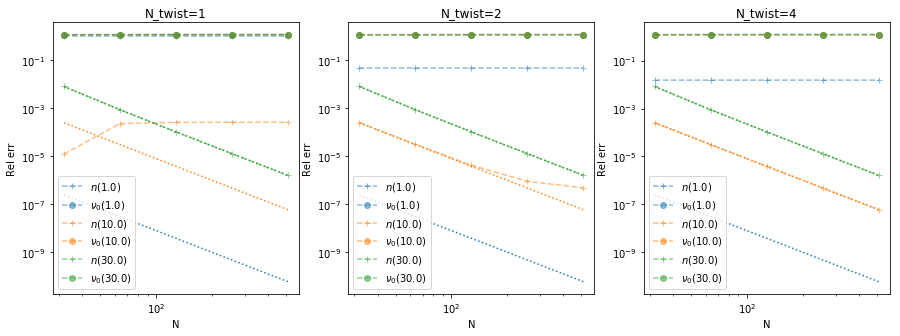

In [14]:
Ns = 2**np.arange(5, 10)
Ls = [1.0, 10.0, 30.0]
N_twists = [1, 2, 4]
plt.figure(figsize=(5*len(N_twists), 5))
for _n, N_twist in enumerate(N_twists):
    res_NL, res_UV = get_errs(Ns=Ns, Ls=Ls, N_twist=N_twist)
    n_, nu_ = np.array(res_NL).T
    plt.subplot(101 + len(N_twists)*10 + _n)
    for _i, L in enumerate(Ls):
        _l, = plt.loglog(Ns, abs(n_[:, _i]-n)/n, '--+', label=f'$n({L})$', alpha=0.5)
        plt.loglog(Ns, abs(nu_[:, _i]-v_0)/v_0, '--o', c=_l.get_c(),
                   label=r'$\nu_0({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(res_UV[_i, :, 0])/n, ':', c=_l.get_c())
        #plt.loglog(Ns, abs(res_UV[_i, :, 1])/delta, ':', c=_l.get_c())
    plt.ylabel('Rel err')
    plt.xlabel('N')
    plt.legend()
    plt.title(f"N_twist={N_twist}")

It can be seen from the above plots, $\nu$ seems to converge very poorly, while the density become accurater as $L$,$N$ and twist number increase.

## <font color="red">Chunde: To Do</font>

Demonstrate the IR and UV convergence of the finite basis.

In [10]:
import vortex_2d;reload(vortex_2d)
s = vortex_2d.BCS_1D(Lx=32.0, Nx=2)
res = s.get_densities(mus=(mu, mu), delta=delta,N_twist=1)
res.nu.mean(), (res.n_a + res.n_b).mean()

((-0.031192095984646426+0j), 0.06625531147752446)

$$
  \begin{pmatrix}
    k^2 & 0\\
    0 & -k^2
  \end{pmatrix}
$$

$$
  n_a = \sum_{n} \abs{\psi_n(x)}^2f(E_n), \qquad
  \sum_{n}\d{x} \abs{\psi(x_n)}^2 = 1, \qquad
  \sum_{n}\abs{u(x_n)}^2 = 1, \qquad
  \psi_n(x) = \frac{u_n(x)}{\sqrt{\d{x}}}
$$

## Error Check
* We also need to check the errors for the vortex_2d class

In [12]:
%pylab inline --no-import-all
import bcs;reload(bcs)
import homogeneous;reload(homogeneous)

delta = 1.0
mu_eff = 1.0
m = 1.0
v_0, n, mu, e_0 = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)

def get_err(N, L, N_twist=1):
    b = vortex_2d.BCS_1D(T=0, Nx=N, Lx=L)
    res = b.get_densities(mus=(mu_eff, mu_eff), delta=delta,N_twist=N_twist)  
    k_max = np.pi*N/L
    dn_UV = 2*b.m**2*delta**2/3/np.pi/k_max**3 + 8*b.m**3*mu_eff*delta**2/5/np.pi/k_max**5
    dd_UV = v_0*b.m*delta/np.pi/k_max + 2*v_0*b.m**2*mu_eff/3/np.pi/k_max**3
    return [[(res.n_a + res.n_b).mean(), res.nu.mean()],[dn_UV, dd_UV]]

def get_errs(Ns, Ls, N_twist=1):
    Ns, Ls = np.asarray(Ns), np.asarray(Ls)
    res_NL = []
    res_UV = []
    for L in Ls:
        res_NL_ = []
        res_UV_ = []
        for N in Ns:
            n_d, d_UV = get_err(N=N, L=L, N_twist=N_twist)
            res_NL_.append(n_d)
            res_UV_.append(d_UV)
        res_NL.append(res_NL_)
        res_UV.append(res_UV_)
    return np.array([res_NL, res_UV])

Populating the interactive namespace from numpy and matplotlib


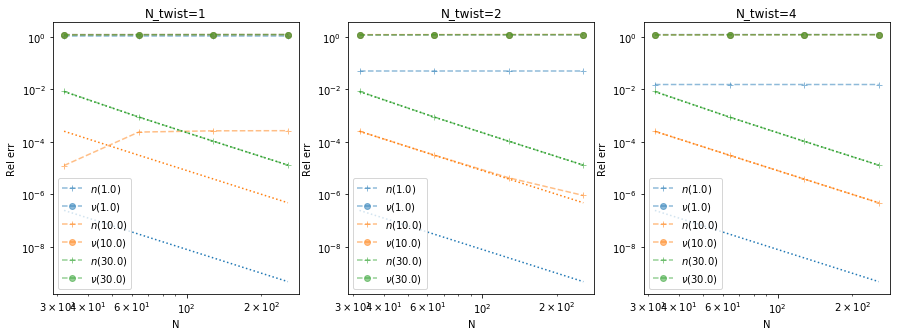

In [15]:
Ns = 2**np.arange(5, 9)
Ls = [1.0, 10.0, 30.0]
N_twists = [1, 2, 4]
plt.figure(figsize=(5*len(N_twists), 5))
for _n, N_twist in enumerate(N_twists):
    res_NL, res_UV = get_errs(Ns=Ns, Ls=Ls, N_twist=N_twist)
    n_, nu_ = np.array(res_NL).T
    plt.subplot(101 + len(N_twists)*10 + _n)
    for _i, L in enumerate(Ls):
        _l, = plt.loglog(Ns, abs(n_[:, _i]-n)/n, '--+', label=f'$n({L})$', alpha=0.5)
        plt.loglog(Ns, abs(nu_[:, _i]-v_0)/v_0, '--o', c=_l.get_c(),
                   label=r'$\nu({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(res_UV[_i, :, 0])/n, ':', c=_l.get_c())
        #plt.loglog(Ns, abs(res_UV[_i, :, 1])/delta, ':', c=_l.get_c())
    plt.ylabel('Rel err')
    plt.xlabel('N')
    plt.legend()
    plt.title(f"N_twist={N_twist}")

Things seems right for the density, but  not quite right for the $\nu$, need to check again!

# To-do
* Workout how the error for $\nu$ scales

We start with the base BCS class which solves the problem in a 1D periodic universe.  This class will form the base for subsequent work, but is limited by the issue discussed above with discrete $k_n$.  As we shall see, there are two forms of errors: UV errors resulting from a limited $k_\max = \pi N/L$ and IR errors from the discrete $\d{k} = \pi/L$.  To estimate the UV errors, we consider the asymptotic form of the integrals:

$$
  \delta_{UV}\Delta = \frac{v_0}{2}\overbrace{2}^{\pm k}\int_{k_\max}^{\infty}
    \frac{\d{k}}{2\pi}\;\frac{\Delta}{\sqrt{\epsilon_+^2 + \Delta^2}} 
  \approx v_0\int_{k_\max}^{\infty} \frac{\d{k}}{2\pi}\;\frac{2m\Delta}{\hbar^2k^2}
  = \frac{v_0m\Delta}{\pi\hbar^2k_\max} + \frac{2v_0 m^2\mu_\mathrm{eff}}{3\pi\hbar^4k_\max^3},\\
  \delta_{UV}n_+ = 2\int_{k_\max}^{\infty}\frac{\d{k}}{2\pi}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  \approx \int_{k_\max}^{\infty}\frac{\d{k}}{2\pi}
    \frac{4m^2\abs{\Delta}^2}{\hbar^4k^4}
  = \frac{2m^2\abs{\Delta}^2}{3\pi\hbar^4k_{\max}^3} 
    + \frac{8m^3\mu_{\mathrm{eff}}\abs{\Delta}^2}{5\pi \hbar^6 k_\max^5}
$$

The error in $\Delta$ is largest, so we can set the lattice spacing to achieve the desired accuracy:

$$
  \frac{L}{N} \lesssim \frac{\pi^2\hbar^2}{v_0 m}\frac{\delta_{UV}\Delta}{\Delta}.
$$